Advanced Lane Finding
=====================

Camera calibration
------------------

Calibrating camera using 9 x 6 checkboard images in camera_cal/

Example Image:

![GitHub Logo](camera_cal/calibration1.jpg)




In [3]:
#Based on OpenCV tutorial Camera Clibration

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


img = cv2.imread("camera_cal/calibration1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("Calibrated!")

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    

Calibrated!


Test calibration on chessboard image for validation.



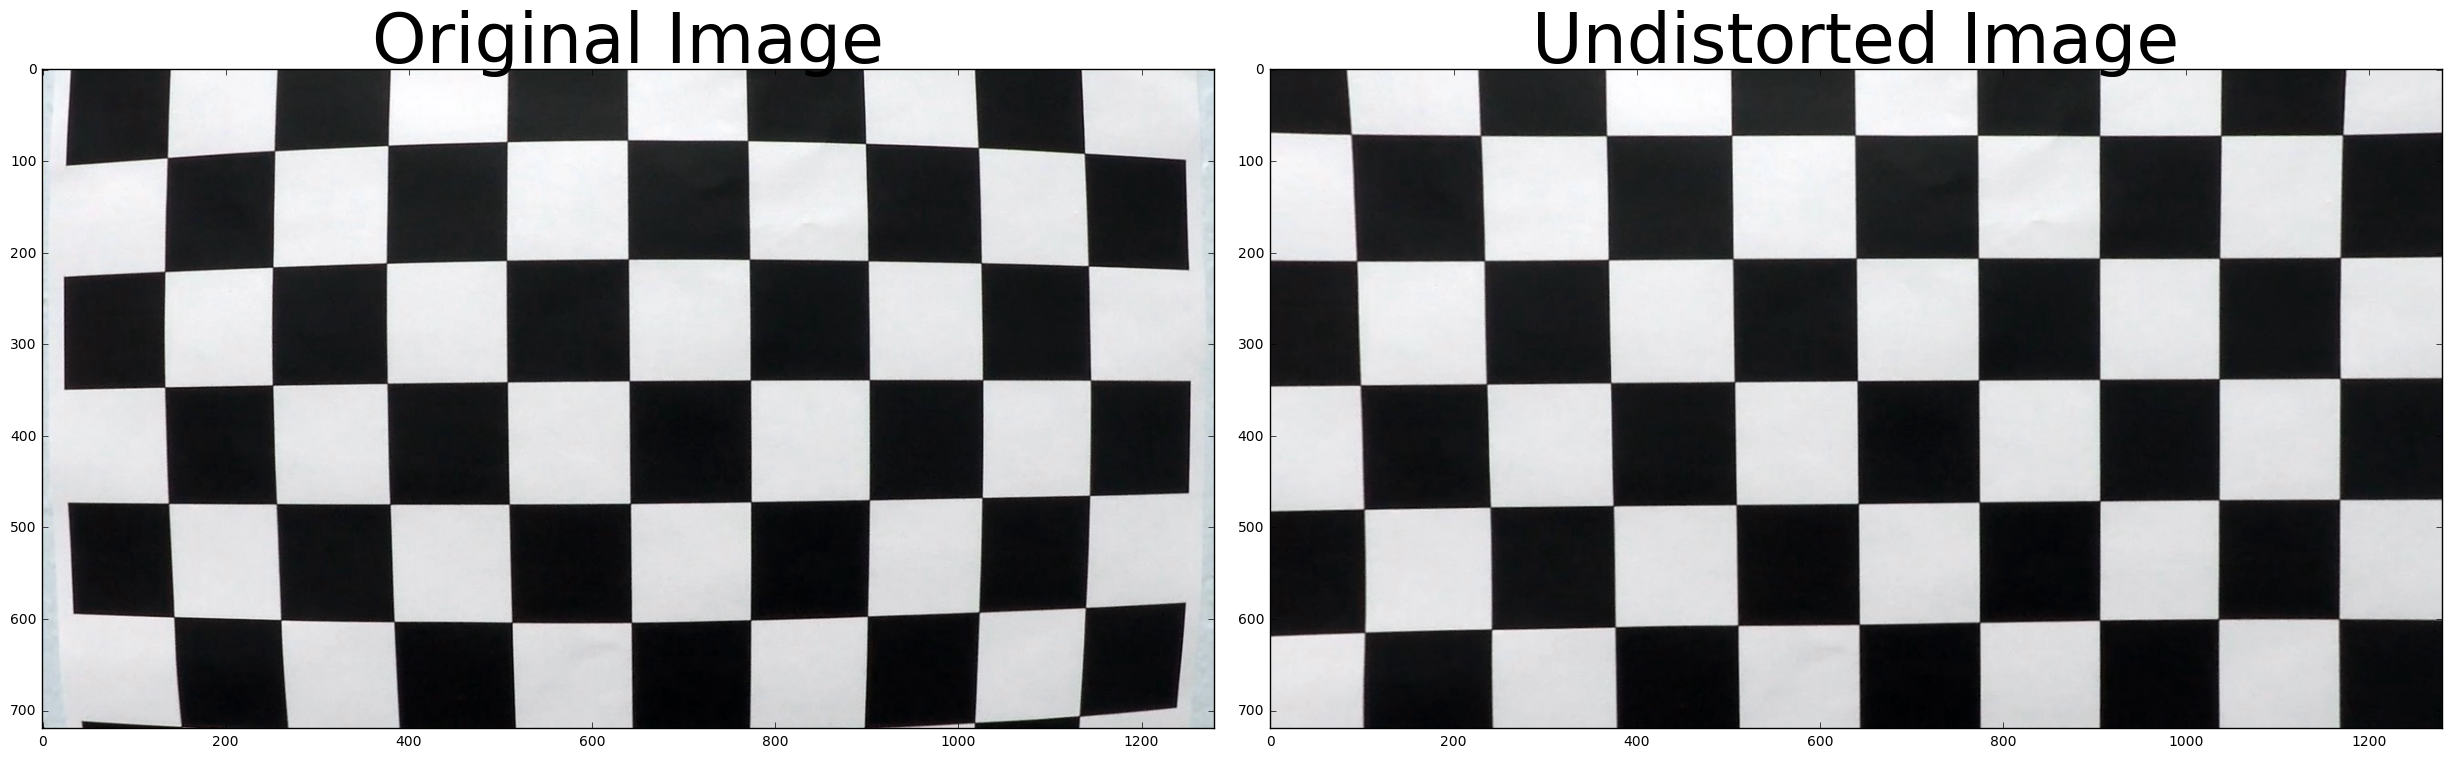

In [5]:
import matplotlib.pyplot as plt

undistorted = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


Color/gradient threshold
------------------------

Explore gradients in input images

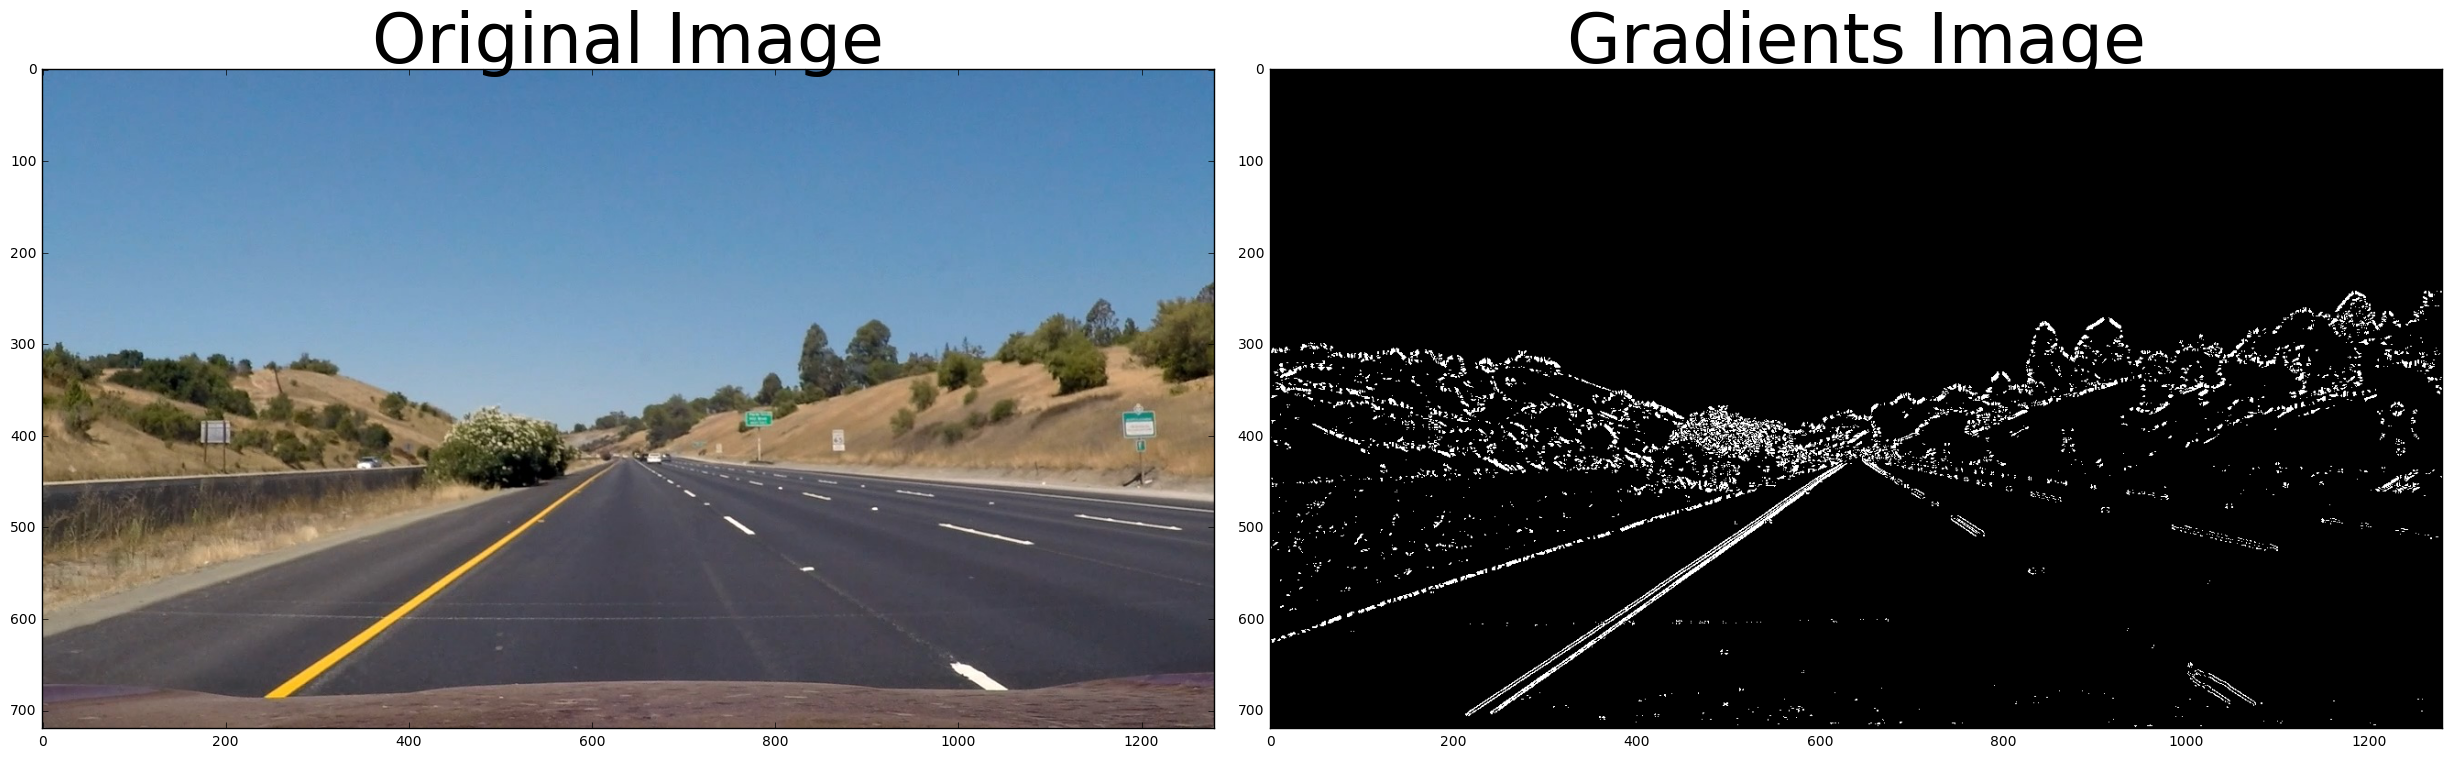

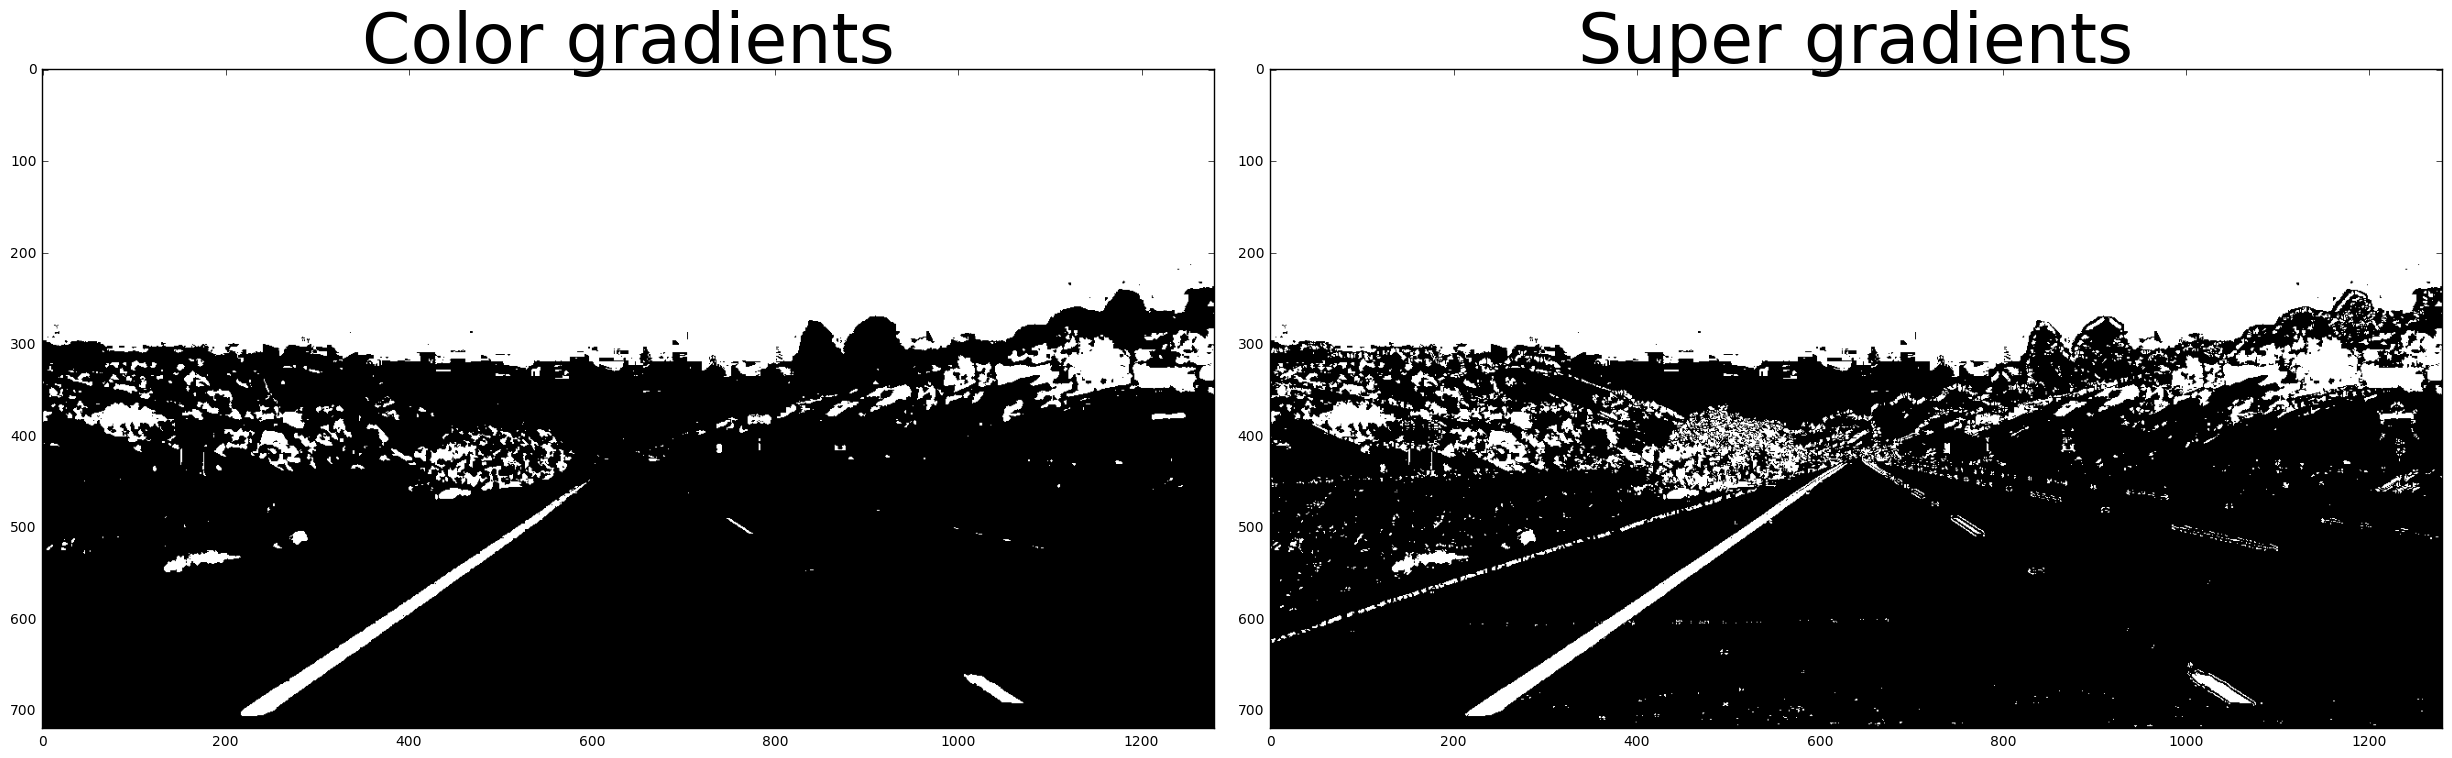

In [7]:
test_image1 = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB) 


import numpy as np
import cv2


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


# Choose a Sobel kernel size

image = test_image1
image = undistort(image)
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3)) # 0, np.pi/2))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

#color gradient
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

super_combined = np.zeros_like(dir_binary)
super_combined[(combined == 1) | (binary == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Gradients Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary, cmap='gray')
ax1.set_title('Color gradients', fontsize=50)
ax2.imshow(super_combined, cmap='gray')
ax2.set_title('Super gradients', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


Perspective transform
---------------------

Transform to birdseye view for easier detection of lan curvature. Find good parameters using a straigt lane.

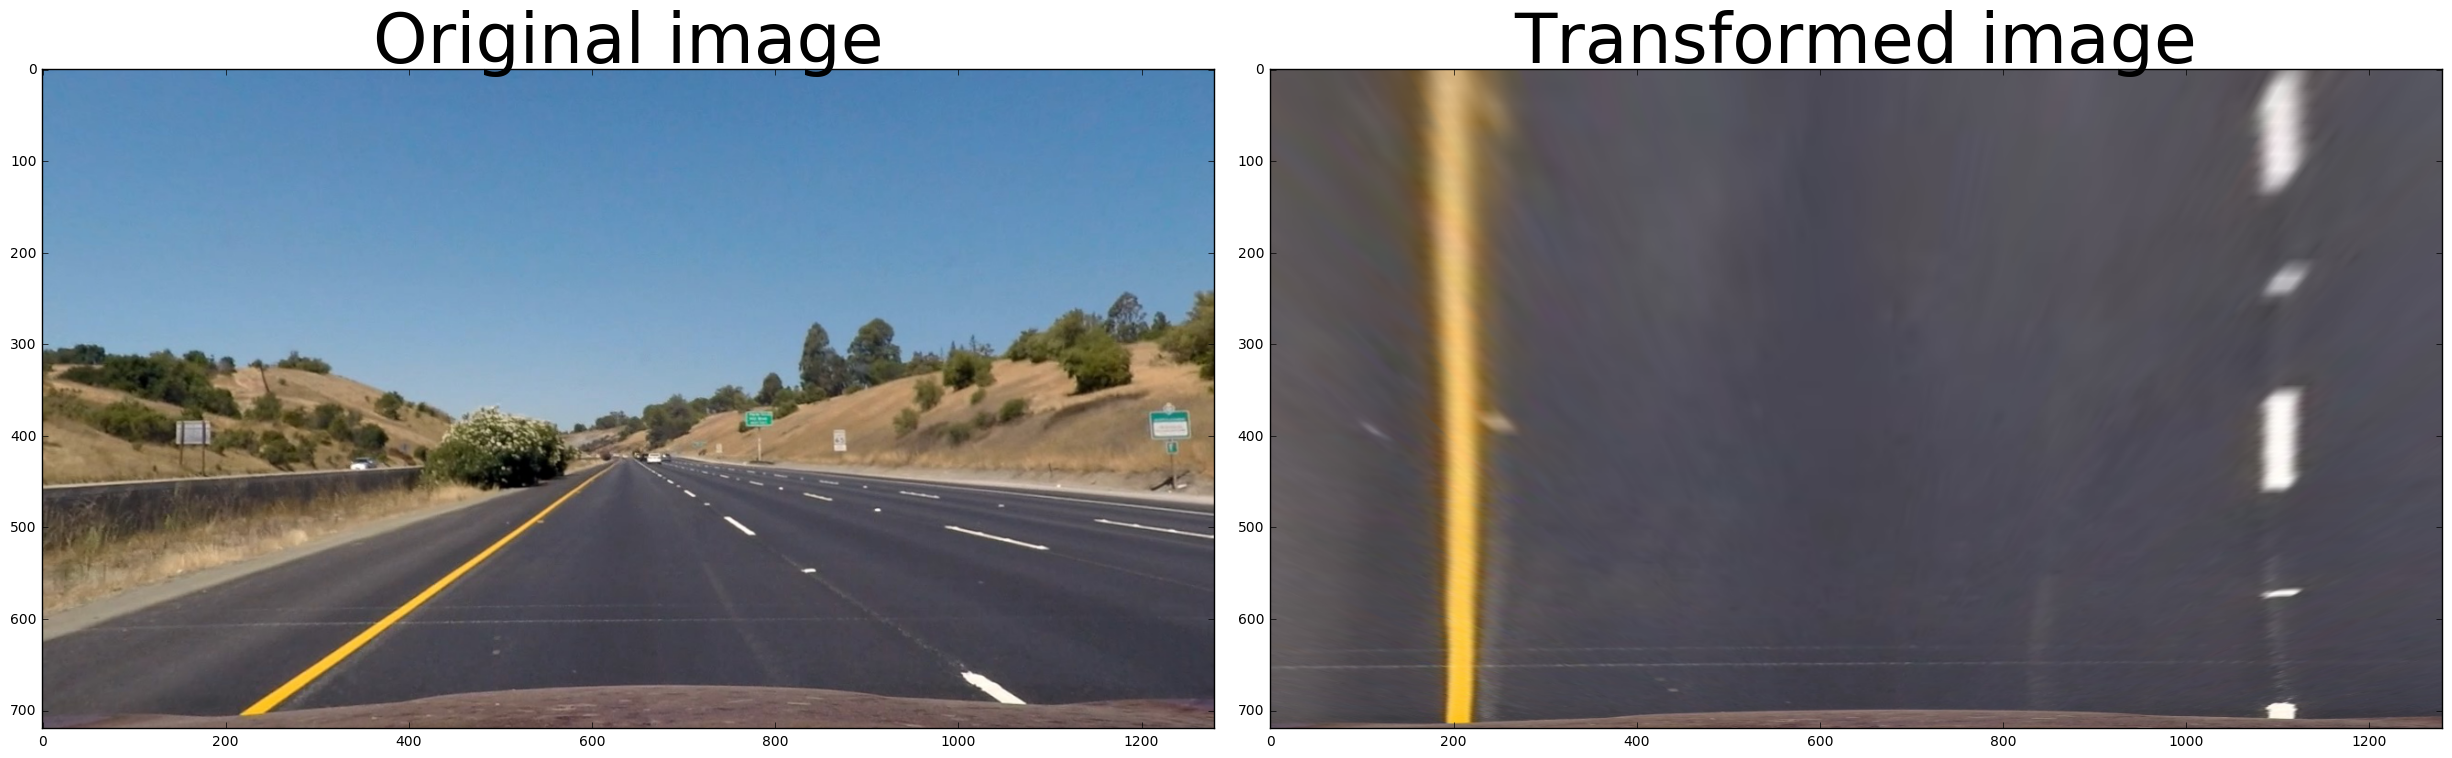

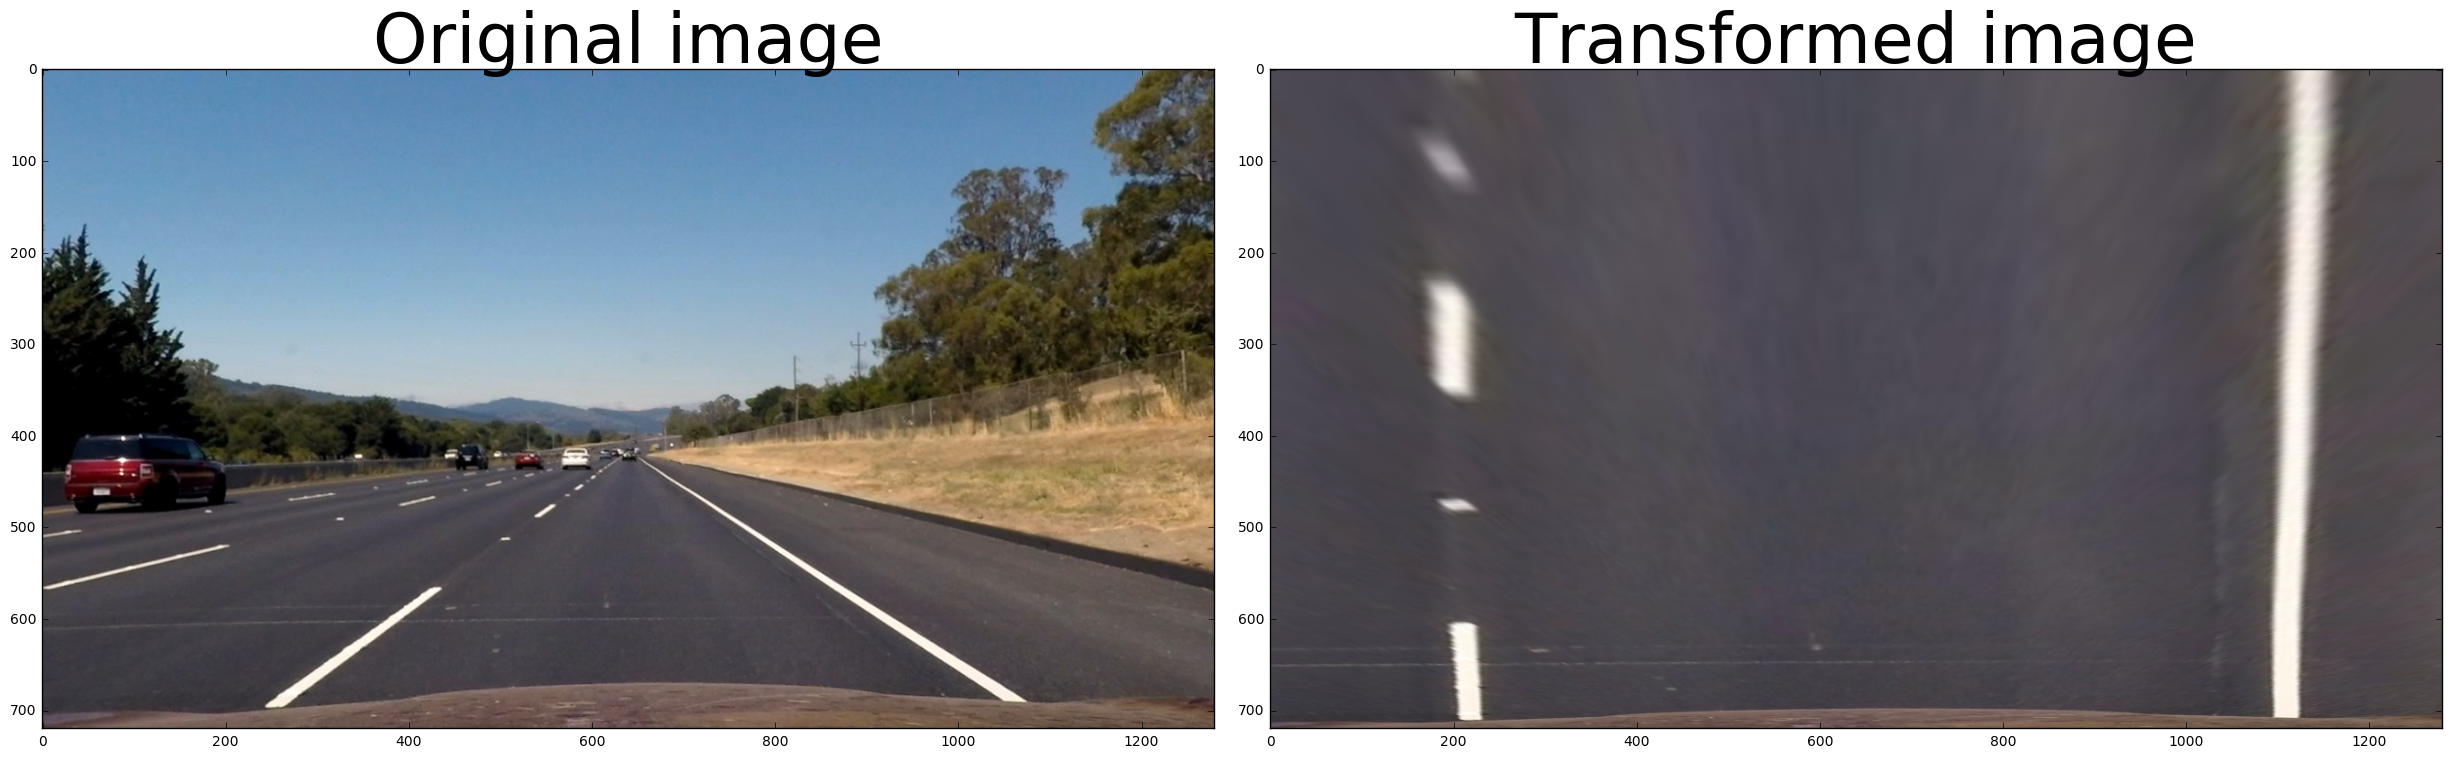

In [11]:
def persp_trans(im):

    width = im.shape[1]
    height = im.shape[0] 

    offset_y_top = 460
    offset_y_bottom = 0
    offset_x_top = 556
    offset_x_bottom = 0
    src = np.float32([[offset_x_top, offset_y_top], [width-offset_x_top, offset_y_top], [width-offset_x_bottom, height-offset_y_bottom], [offset_x_bottom, height-offset_y_bottom]])

    dst_width = width - 2* offset_x_bottom
    dst_height = height
    dst = np.float32([[0,0],[dst_width,0],[dst_width,dst_height],[0,dst_height]])

    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(im, M, (dst_width, dst_height), flags=cv2.INTER_LINEAR)
    return warped

straight_lane = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
straight_lane = undistort(straight_lane)
corrected = persp_trans(straight_lane)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(straight_lane)
ax1.set_title('Original image', fontsize=50)
ax2.imshow(corrected)
ax2.set_title('Transformed image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

straight_lane2 = cv2.cvtColor(cv2.imread('test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)
straight_lane2 = undistort(straight_lane2)
corrected2 = persp_trans(straight_lane2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(straight_lane2)
ax1.set_title('Original image', fontsize=50)
ax2.imshow(corrected2)
ax2.set_title('Transformed image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

Perspective transform on a curved lane
--------------------------------------

Lets check what it looks like on an image with a curved lane


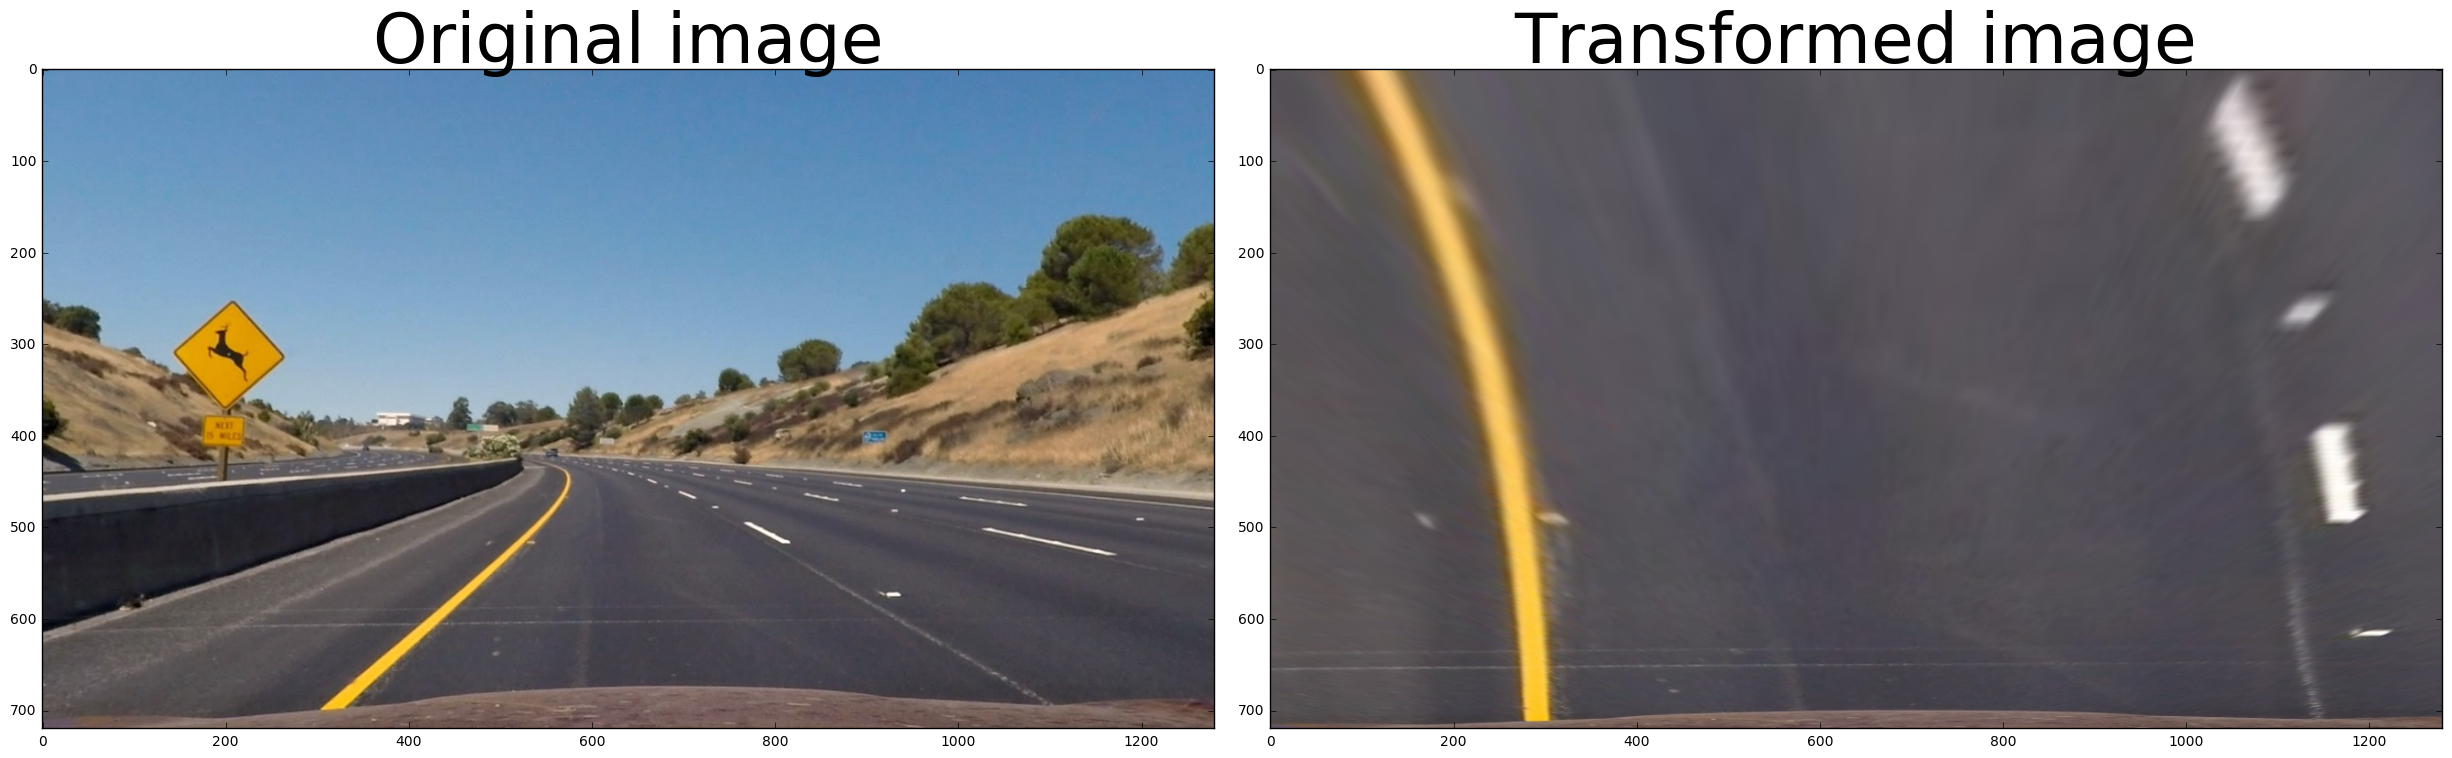

In [14]:
curved_lane = cv2.cvtColor(cv2.imread('test_images/test2.jpg'), cv2.COLOR_BGR2RGB)
curved_lane = undistort(curved_lane)
corrected = persp_trans(curved_lane)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(curved_lane)
ax1.set_title('Original image', fontsize=50)
ax2.imshow(corrected)
ax2.set_title('Transformed image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

Looks good!

In [156]:
import cv2
import matplotlib.pyplot as plt
from glob import glob

def camera_calibration():
    for name in glob("camera_cal/*.jpg"):
        print(name)
    


Putting it all together
=======================

